## KD Tree Exercises

### Load data

As before, start by loading in the data!

In [4]:
using JuliaDB, MNIST 

rescale(A, dim::Integer=1) = (A .- mean(A, dim)) ./ max.(std(A, dim), eps())

# Fruit dataset
fruit_table = loadtable(["../training/data/Apple_Golden_1.dat","../training/data/bananas.dat"]; delim = '\t', filenamecol=:apple => (x) -> x == "../training/data/Apple_Golden_1.dat" ? true : false)

matdata = hcat(columns(fruit_table)...)
fruit_data = rescale(matdata[:,2:end], 1)
fruit_labels = ifelse.(matdata[:,1].==1, "Apple","Banana")

# Mystery dataset
mystery_data, labels = traindata()
N = 2500
mystery_data = rescale(convert(Matrix{Float64}, mystery_data[:, 1:N])',1)
mystery_labels = Int.(labels)[1:N];

### Build KD Trees

Build `KDTree`s from your fruit and mystery data sets called `fruit_kdtree` and `mystery_kdtree`.

#### Solution

In [5]:
using NearestNeighbors

fruit_kdtree = KDTree(fruit_data')
mystery_kdtree = KDTree(mystery_data')

NearestNeighbors.KDTree{StaticArrays.SArray{Tuple{784},Float64,1,784},Distances.Euclidean,Float64}
  Number of points: 2500
  Dimensions: 784
  Metric: Distances.Euclidean(0.0)
  Reordered: true

### KNN

Try out `knn` on your kd trees. For each dataset, look at the ten nearest neighbors for a random point in your dataset. Do those ten nearest neighbors have the correct classification? (Try this for a few random points!)

#### Solution for fruits: 

First, let's find the indices of the neighbors of a random point

In [6]:
# Define the number of nearest neighbors
knearest = 10
# Randomly choose the index of one of the points in your dataset
fruit_i = rand(1:size(fruit_data, 1))
# Use this index to grab the relevant point in  your dataset
fruit_point = fruit_data[fruit_i, :]
# Perform KNN to get the knearest nearest neighbors
fruit_idxs, dists = knn(fruit_kdtree, fruit_point, knearest, true)
println("Randomly chose point $fruit_i, whose nearest neighbors are points $fruit_idxs")

Randomly chose point 471, whose nearest neighbors are points [471, 467, 477, 476, 478, 479, 470, 466, 473, 472]


Now that we have these indices, let's check the labels of all of these points. Do they match the label of the randomly chosen point?

In [7]:
fruit_labels[fruit_i]

"Apple"

In [8]:
fruit_labels[fruit_idxs]

10-element Array{String,1}:
 "Apple"
 "Apple"
 "Apple"
 "Apple"
 "Apple"
 "Apple"
 "Apple"
 "Apple"
 "Apple"
 "Apple"

The labels of your neighbors should be the same as the label of your randomly chosen point!

Now let's try this for the mystery dataset (which, if you haven't noticed yet, is the MNIST dataset. :) )

#### Solution for MNIST:


In [9]:
# Define the number of nearest neighbors
knearest = 10
# Randomly choose the index of one of the points in your dataset
mnist_i = rand(1:size(mystery_data, 1))
# Use this index to grab the relevant point in  your dataset
mnist_point = mystery_data[mnist_i, :]
# Perform KNN to get the knearest nearest neighbors
mnist_idxs, dists = knn(mystery_kdtree, mnist_point, knearest, true)
println("Randomly chose point $mnist_i, whose nearest neighbors are points $mnist_idxs")

Randomly chose point 1527, whose nearest neighbors are points [1527, 2479, 1975, 1962, 1207, 1357, 441, 597, 2069, 57]


Now let's check the labels!

In [10]:
mystery_labels[mnist_i]

5

In [11]:
mystery_labels[mnist_idxs]

10-element Array{Int64,1}:
 5
 5
 8
 5
 5
 5
 0
 0
 8
 0

Whether or not this works well will probably depend on which integer you randomly draw first. From my attempts, for example, it seems that the number 1 is more easily recognized than the number 3.

### Exploring neighborhood size

We would expect that points that are closer together (in terms of their feature similarity) are more likely to be similar to one another than those that are farther apart.

Use kd trees and knn to determine what fraction of the `knearest` nearest neighbors have the same label as a randomly chosen point in each dataset. To gather some statistics, try choosing ~100 random points for each of many neighbor sizes (numbers of nearest neighbors).

Plot how the fraction of like neighbors to a randomly chosen point varies with the number of neighbors investigated. (For example,  you might look at neighborhoods from as small as 1 to as large as the whole dataset.)

#### Solution for fruits

In [12]:
"""
    how_many_like_neighbors(i, neighbors, labels)

Returns the number of point i's neighbors that share i's labels.

Takes the index of a point (i), an array of indices for i's neighbors (neighbors), and the labels for the points in the dataset from which i and the elements of neighbors come. 
"""
function how_many_like_neighbors(i, neighbors, labels)
    # grab the label of the randomly chosen (ith) point
    label_i = labels[i]
    # determine labels of the ith point's neighbors
    neighbor_labels = labels[neighbors]
    # count how many of the neighbors are like point i
    sum = 0
    for n in neighbor_labels
        if n == label_i
            sum += 1
        end
    end
    return sum
end

how_many_like_neighbors

In [13]:
"""
    fraction_like_neighbors(data, knearest, labels, samples = 100)

Returns the average fraction of `knearest` nearest neighbors that have the same label as a randomly chosen point.

Takes a dataset, the number of nearest neighbors, the labels associated with the dataset, and, optionally, the number of samples to use to determine this average (the number of randomly chosen points drawn).
"""
function fraction_like_neighbors(data, knearest, labels, samples = 100)
    kdtree = KDTree(data')
    matching_neighbors = 0
    for i in 1:samples
        # grab a random point
        j = rand(1:size(data, 1))
        point = data[j, :]
        # determine the neighbors of that random point
        neighbor_idxs, dists = knn(kdtree, point, knearest, true)
        # account for all neighbors with the same label as the rndm point
        matching_neighbors += how_many_like_neighbors(j, neighbor_idxs, labels)
    end
    # Determine the average fraction of matching neighbors from `samples` number of samples
    return matching_neighbors/(samples * knearest)
end

fraction_like_neighbors

We can call the above function to determine the fraction of like neighbors for 100 nearest neighbors like

In [14]:
like_neighbor_ratio = fraction_like_neighbors(fruit_data, 100, fruit_labels)

0.9921

Now let's plot how this fraction changes with neighborhood size.

In [15]:
using Plots
gr()

Plots.GRBackend()

In [18]:
neighborhood_sizes = push!([x for x in 5:15:150], [x for x in 200:60:980]...);

In [17]:
fractions_like_nn = []
for knearest in neighborhood_sizes
    like_neighbor_ratio = fraction_like_neighbors(fruit_data, knearest, fruit_labels)
    push!(fractions_like_nn, like_neighbor_ratio)
end

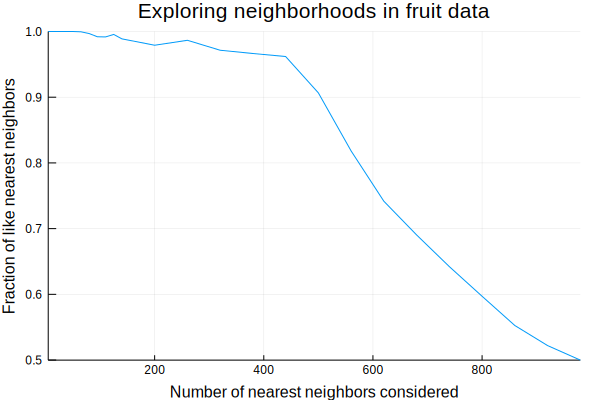

In [21]:
plot(neighborhood_sizes, fractions_like_nn, legend = false)
xlabel!("Number of nearest neighbors considered")
ylabel!("Fraction of like nearest neighbors")
title!("Exploring neighborhoods in fruit data")

What we see in the above plot is that KDTrees are very good at grouping like data in our fruit dataset. Neighbors are mostly predicted to be like the randomly chosen point of origin until around the time that the number of neighbors chosen is larger than the number of like data points.

#### Solution for mystery data/mnist data

As before, we can determine the fraction of like neighbors for 100 nearest neighbors like

In [22]:
like_neighbor_ratio = fraction_like_neighbors(mystery_data, 100, mystery_labels)

0.5467

Let's see how this number changes with neighborhood size

In [29]:
neighborhood_sizes = [5 * 2^i for i in 0:8]

9-element Array{Int64,1}:
    5
   10
   20
   40
   80
  160
  320
  640
 1280

In [30]:
fractions_like_nn = []
for knearest in neighborhood_sizes
    like_neighbor_ratio = fraction_like_neighbors(mystery_data, knearest, mystery_labels)
    push!(fractions_like_nn, like_neighbor_ratio)
end

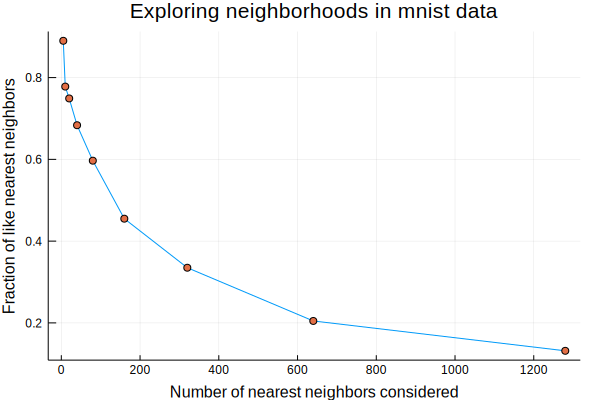

In [32]:
plot(neighborhood_sizes, fractions_like_nn, legend = false)
scatter!(neighborhood_sizes, fractions_like_nn, legend = false)
xlabel!("Number of nearest neighbors considered")
ylabel!("Fraction of like nearest neighbors")
title!("Exploring neighborhoods in mnist data")

This works significantly less well for this dataset! Since we have 2500 data points and 10 digits, we would expect to have ~250 points in each dataset. Yet here KDTrees can only identify like neighbors for very small neighborhoods.